In [195]:
# Import the packages needed for the examples included in this notebook
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# Import the python-control package
try:
    import control as ct
    print("python-control", ct.__version__)
except ImportError:
    %pip install control
    import control as ct

python-control 0.10.0


(0.0, 50.0)

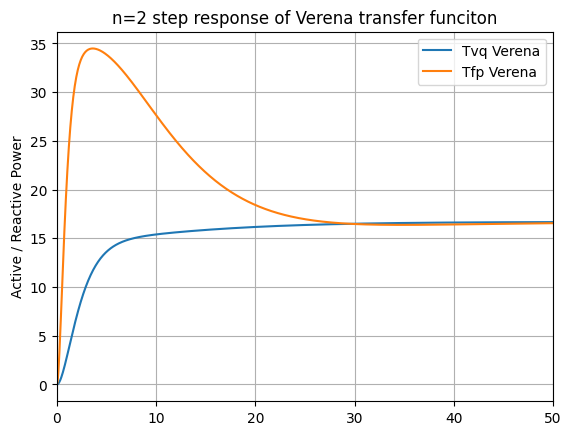

In [197]:
# get transfer function from verena's paper, second order
ss = ct.tf('s')  # create a transfer function variable
Tfcr_verena = 0.2963 / (ss**2 + 0.2667*ss + 0.01778)
# First transfer function T_des,ffr^fp(s, α)
num1 = [143.7, 154.6, 59.75, 7.599, 0]  # numerator coefficients
den1 = [1, 5.17, 9, 6.26, 2.03, 0.3077, 0.0176]  # denominator coefficients
Tffr_verena = ct.TransferFunction(num1, den1)
# Second transfer function T_des^vq(s, α)
num2 = [9.422, 2.56, 0.1897]  # numerator coefficients
den2 = [1, 1.867, 1.084, 0.1991, 0.01137]  # denominator coefficients
Tvq_verena = ct.TransferFunction(num2, den2)
Tfp_verena = Tfcr_verena + Tffr_verena  # FFR + FCR service

# plot verena transfer function
# get step response
tlim = [0, 50]
t = np.linspace(tlim[0], tlim[1], 1000)
t, yvq = ct.step_response(Tvq_verena, T=t)
t, fp = ct.step_response(Tfp_verena, T=t)
plt.plot(t, yvq, label='Tvq Verena')
plt.plot(t, fp, label='Tfp Verena')
plt.legend()
plt.grid()
plt.title('n=2 step response of Verena transfer funciton')
plt.ylabel('Active / Reactive Power')
plt.xlim(tlim)

## define helpers

In [312]:
# s = ct.tf('s')  # create a transfer function variable
s = sp.symbols('s')  # create a symbolic variable for SymPy

def pade(t, n=2):
    # [n/n] Pade for e^{-t s}: ((1 - s t /(2n))^n)/((1 + s t /(2n))^n)
    return ((1 - s*t/(2*n))**n) / ((1 + s*t/(2*n))**n)

def Y_segment(yi, yj, ti, tj, n=2):
    # Eq. (11): Y_ij(s) = ((yi - yj)/s + d/s^2) * (e^{-ti s} - e^{-tj s})
    d = (yj - yi) / (tj - ti)
    return (yi + d/s) * pade(ti, n) - (yj + d/s) * pade(tj, n)

def sympy_to_tf(T_sym, s=sp.symbols('s')):
    """
    Convert a SymPy rational function T(s) into a python-control TransferFunction.
    """
    num, den = sp.fraction(sp.together(T_sym))   # separate numerator and denominator
    num_poly = sp.Poly(sp.expand(num), s)
    den_poly = sp.Poly(sp.expand(den), s)

    # coefficients in descending powers of s
    num_coeffs = [float(c) for c in num_poly.all_coeffs()]
    den_coeffs = [float(c) for c in den_poly.all_coeffs()]

    return ct.TransferFunction(num_coeffs, den_coeffs)

## FCR control

In [313]:
ti, ta, Dp = 2, 30, 0.06

In [319]:
def build_fcr_tf(ti, ta, Dp, n=2, t_final=100,
                 cutoff_mag=[],
                 rm_zeros=False,
                 gain=1) -> ct.TransferFunction:
    t1, t2, t3 = ti, ta, t_final
    y1, y2, y3 = 0, 1.0 / Dp, 1.0 / Dp
    ts = [t1, t2, t3]
    ys = [y1, y2, y3]

    # Build Y(s) with formula 11
    Y = Y_segment(ys[0], ys[1], ts[0], ts[1], n=n)  # first segment
    Y += Y_segment(ys[1], ys[2], ts[1], ts[2], n=n)  # second segment
    # for i in range(len(ts) - 1):
    #     yi, yj, ti, tj = ys[i], ys[i + 1], ts[i], ts[i + 1]
    #     d = (yj - yi) / (tj - ti)
    #     Y += yi * pade(ti, n) - yj * pade(tj, n) + d/s * (pade(ti, n) - pade(tj, n))
    T = sympy_to_tf(sp.simplify(Y))

    # now cut off the poles and zeros that are too low or high in magnitude
    if cutoff_mag!=[]:
        poles = T.poles()
        zeros = T.zeros()
        # Cut off poles
        poles = [p for p in poles if np.abs(p) > cutoff_mag[0] and np.abs(p) < cutoff_mag[1]]
        if rm_zeros:
            zeros = []
        # build new transfer function
        return ct.zpk(zeros, poles, gain)

    return T

In [320]:
Tfcr_des = build_fcr_tf(ti, ta, Dp, n=2, cutoff_mag=[0.08, 1], rm_zeros=True,
                        gain=0.2963)

(0.0, 50.0)

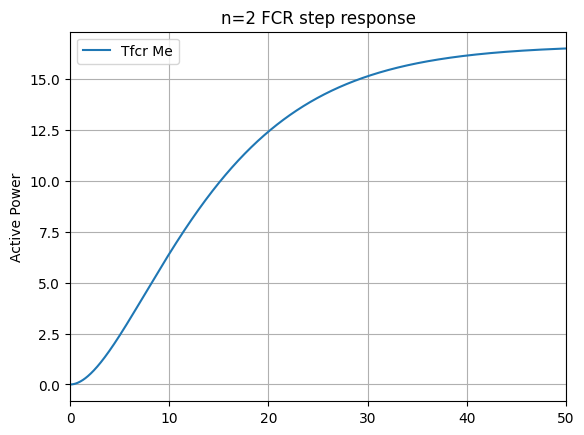

In [ ]:
t, yfcr_verena = ct.step_response(Tfcr_verena, T=t)
t, yfcr_des = ct.step_response(Tfcr_des, T=t)
plt.plot(t, yfcr_verena, label='Tfcr Verena')
plt.plot(t, yfcr_des, label='Tfcr Me')
plt.legend()
plt.grid()
plt.title('n=2 FCR step response')
plt.ylabel('Active Power')
plt.xlim(tlim)

In [281]:
Tfcr_verena

TransferFunction(array([0.2963]), array([1.     , 0.2667 , 0.01778]))

In [282]:
Tfcr_des

TransferFunction(array([0.2963]), array([1.   , 0.6  , 0.12 , 0.008]))

## voltage control

In [185]:
tvq90, tvq100, Dq = 5, 60, 0.06

In [339]:
import sympy as sp

def build_vq_tf(tvq90, tvq100, Dq, n=2, t_final=1e3,
                cutoff_mag=[],
                 gain=1) -> ct.TransferFunction:
    """
    Construct T_des^vq(s) using the paper's method:
      1) build the unit-step output Y(s) from two linear segments,
      2) then T(s) = s * Y(s),
      3) voltage-control levels: 0 -> 0.9/Dq at tvq90 -> 1/Dq at tvq100.
    n: order of Pade approximation for e^{-t s}.
    Returns a ct.TransferFunction.
    """
    # voltage-control target levels are normalized by Dq
    y1 = 0
    y2 = 0.9 / Dq
    y3, y4 = 1.0 / Dq, 1.0 / Dq
    t1, t2, t3, t4 = 0.0, tvq90, tvq100, t_final
    
    # Build Y(s) from segments
    Y = Y_segment(y1, y2, t1, t2) + Y_segment(y2, y3, t2, t3) + Y_segment(y3, y4, t3, t4)
    T = sympy_to_tf(sp.simplify(Y))

    # quick sanity check: final value of step response must be 1/Dq
    # lim_{s->0} T(s) = 1/Dq
    # assert sp.N(sp.limit(T, s, 0)) == sp.N(1/Dq)
    # now cut off the poles and zeros that are too low or high in magnitude
    if cutoff_mag!=[]:
        poles = T.poles()
        zeros = T.zeros()
        # Cut off poles
        poles = [p for p in poles if np.abs(p) > cutoff_mag[0] and np.abs(p) < cutoff_mag[1]]
        zeros = [z for z in zeros if np.abs(z) > cutoff_mag[0] and np.abs(z) < cutoff_mag[1]]
        # build new transfer function
        return ct.zpk(zeros, poles, gain)

    return T

In [340]:
Tvq_des = build_vq_tf(tvq90, tvq100, Dq, n=2, cutoff_mag = [.1, 1], gain=9)

In [342]:
# compare zeros
cutoff_mag = [.1, 1]
print(Tvq_verena.zeros())
print(Tvq_des.zeros())
print([z for z in Tvq_des.zeros() if np.abs(z) > cutoff_mag[0] and np.abs(z) < cutoff_mag[1]])

[-0.13585226+0.04096209j -0.13585226-0.04096209j]
[-0.1017339+0.03749778j -0.1017339-0.03749778j]
[(-0.10173389538889951+0.037497775976482565j), (-0.10173389538889951-0.037497775976482565j)]


In [343]:
# compare poles
print(Tvq_verena.poles())
print(Tvq_des.poles())
print([p for p in Tvq_des.poles() if np.abs(p) > cutoff_mag[0] and np.abs(p) < cutoff_mag[1]])

[-0.83194602+0.j -0.76800333+0.j -0.13934249+0.j -0.12770816+0.j]
[-0.79999999+0.j -0.80000001+0.j]
[(-0.7999999904586+0j), (-0.8000000095413974+0j)]


(0.0, 50.0)

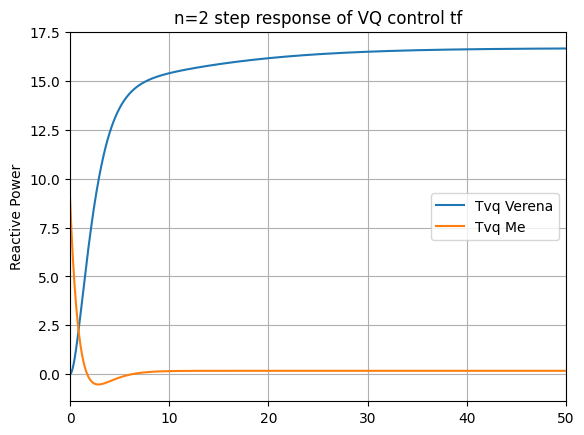

In [341]:
# compare with verena
t, yvq_des = ct.step_response(Tvq_des, T=t)
plt.plot(t, yvq, label='Tvq Verena')
plt.plot(t, yvq_des, label='Tvq Me')
plt.legend()
plt.grid()
plt.title('n=2 step response of VQ control tf')
plt.ylabel('Reactive Power')
plt.xlim(tlim)

# build PI and saturation block

In [ ]:
# set params
saturation_limits = [-1e3, 1e3]
params = {'kp': 1, 'ki': 0.1}

In [379]:
# get sample system
# params from https://www.researchgate.net/publication/353419981_Automatic_Load_Frequency_Control_in_an_Isolated_Micro-grid_with_Superconducting_Magnetic_Energy_Storage_Unit_using_Integral_Controller
tau_PV, K_PV = 1.5, 1
G_PV = ct.tf(K_PV, [tau_PV, 1])  # PV system transfer function

# Convert the linear system to NonlinearIOSystem for interconnection
def pv_update(t, x, u, params={}):
    """PV system state update (from state space representation)"""
    # For first-order system: dx/dt = -x/tau + K*u/tau
    return [(-x[0] + K_PV * u[0]) / tau_PV]

def pv_output(t, x, u, params={}):
    """PV system output"""
    return [x[0]]  # Output is the state (velocity)

# Create nonlinear representation of the PV system
pv_system = ct.NonlinearIOSystem(
    pv_update, pv_output, name='plant',
    inputs=['u'], outputs=['v'], states=['x'])

In [380]:
def pi_update(t, x, u, params={}):
    # Assign variables for inputs and states (for readability)
    v = u[0]                    # current velocity
    vref = u[1]                 # reference velocity
    z = x[0]                    # integrated error

    # Compute the nominal controller output (needed for anti-windup)
    u_a = pi_output(t, x, u, params)

    # saturation block: clip values
    u_a = np.clip(u_a, saturation_limits[0], saturation_limits[1])
    
    return u_a

def pi_output(t, x, u, params={}):
    # Get the controller parameters that we need
    kp = params.get('kp')
    ki = params.get('ki')

    # Assign variables for inputs and states (for readability)
    v = u[0]                    # current velocity
    vref = u[1]                 # reference velocity
    z = x[0]                    # integrated error

    # PI controller
    return kp * (vref - v) + ki * z

control_pi = ct.NonlinearIOSystem(
    pi_update, pi_output, name='control',
    inputs = ['v', 'vref'], outputs = ['u'], states = ['z'],
    params=params)

# Create the closed loop system
closed_loop = ct.interconnect(
    [control_pi, pv_system],
    connections=[
        ['plant.u', 'control.u'],      # Controller output to plant input
        ['control.v', 'plant.v']       # Plant output feeds back to controller
    ],
    inplist=['control.vref'],          # External input is the reference
    outlist=['plant.v'],               # System output is plant velocity
    check_unused=False
)

In [381]:
closed_loop

<InterconnectedSystem:sys[1536]:['u[0]']->['y[0]']>

Time shape: (1000,)
Response outputs shape: (1000,)
Response states shape: (2, 1000)


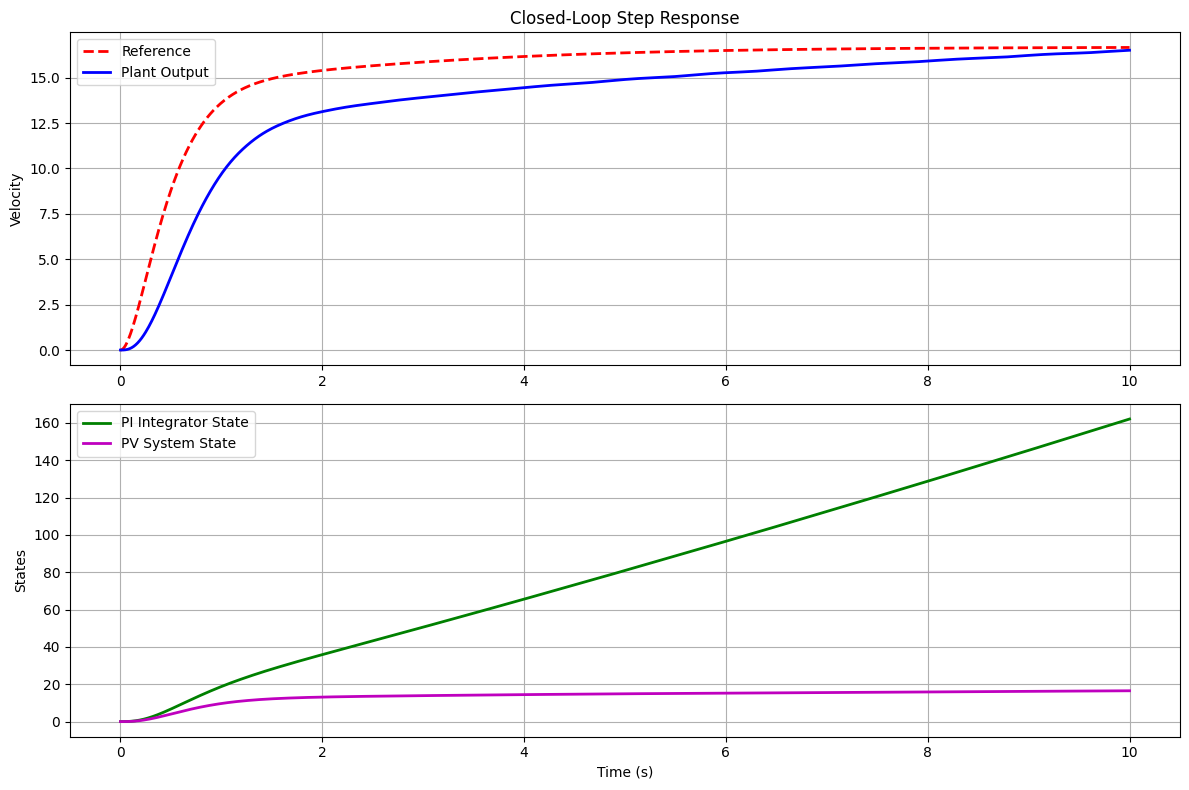

Steady-state error: 0.1537
Settling time (2%): 8.89 seconds
Overshoot: 0.00%


In [382]:
if __name__ == "__main__":
    # Time vector
    t = np.linspace(0, 10, 1000)
    
    # Step reference input
    # use verena yvq
    vref = yvq  # Unit step
    
    # Initial conditions: [PI integrator state, PV system state]
    x0 = [0, 0]
    
    # Simulate the closed-loop response
    response = ct.input_output_response(closed_loop, t, vref, x0)
    
    # Extract outputs and states properly
    plant_output = response.outputs.flatten() if response.outputs.ndim > 1 else response.outputs
    pi_state = response.states[0] if response.states.ndim > 1 else response.states
    pv_state = response.states[1] if response.states.ndim > 1 and response.states.shape[0] > 1 else response.states
    
    # Debug: Print shapes to understand the data structure
    print(f"Time shape: {t.shape}")
    print(f"Response outputs shape: {response.outputs.shape}")
    print(f"Response states shape: {response.states.shape}")
    
    # Plot results
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(t, vref, 'r--', label='Reference', linewidth=2)
    plt.plot(t, plant_output, 'b-', label='Plant Output', linewidth=2)
    plt.ylabel('Velocity')
    plt.title('Closed-Loop Step Response')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    if response.states.ndim > 1:
        plt.plot(t, response.states[0], 'g-', label='PI Integrator State', linewidth=2)
        if response.states.shape[0] > 1:
            plt.plot(t, response.states[1], 'm-', label='PV System State', linewidth=2)
    else:
        plt.plot(t, response.states, 'g-', label='System States', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('States')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print some performance metrics
    final_output = plant_output[-1] if hasattr(plant_output, '__len__') else plant_output
    steady_state_error = abs(vref[-1] - final_output)
    print(f"Steady-state error: {steady_state_error:.4f}")
    
    # Find settling time (within 2% of final value)
    if hasattr(plant_output, '__len__') and len(plant_output) > 1:
        final_value = plant_output[-1]
        settling_idx = np.where(np.abs(plant_output - final_value) <= 0.02 * abs(final_value))[0]
        if len(settling_idx) > 0:
            settling_time = t[settling_idx[0]]
            print(f"Settling time (2%): {settling_time:.2f} seconds")
        
        # Check for overshoot
        max_output = np.max(plant_output)
        overshoot = max(0, (max_output - final_value) / final_value * 100)
        print(f"Overshoot: {overshoot:.2f}%")
    else:
        print("Cannot compute performance metrics - output is scalar")